### Architecture overview
- Resnet18
- KAN
- Bounding Box head output
- Label prediction output ➡ Softmax

#### Library imports

In [ ]:
import torch
import torch.nn as nn

In [ ]:
try:
  from torchinfo import summary
except:
  print("intsalling torchinfo")
  !pip install torchinfo
  from torchinfo import summary

intsalling torchinfo


#### KAN conv Layers

In [ ]:
class KANConvNDLayer(nn.Module):
    def __init__(self, conv_class, norm_class, input_dim, output_dim, spline_order, kernel_size,
                 groups=1, padding=0, stride=1, dilation=1,
                 ndim: int = 2, grid_size=5, base_activation=nn.GELU, grid_range=[-1, 1], dropout=0.0,
                 **norm_kwargs):
        super(KANConvNDLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.spline_order = spline_order
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.dilation = dilation
        self.groups = groups
        self.ndim = ndim
        self.grid_size = grid_size
        self.base_activation = base_activation()
        self.grid_range = grid_range
        self.norm_kwargs = norm_kwargs

        self.dropout = None
        if dropout > 0:
            if ndim == 1:
                self.dropout = nn.Dropout1d(p=dropout)
            if ndim == 2:
                self.dropout = nn.Dropout2d(p=dropout)
            if ndim == 3:
                self.dropout = nn.Dropout3d(p=dropout)
        if groups <= 0:
            raise ValueError('groups must be a positive integer')
        if input_dim % groups != 0:
            raise ValueError('input_dim must be divisible by groups')
        if output_dim % groups != 0:
            raise ValueError('output_dim must be divisible by groups')

        self.base_conv = nn.ModuleList([conv_class(input_dim // groups,
                                                   output_dim // groups,
                                                   kernel_size,
                                                   stride,
                                                   padding,
                                                   dilation,
                                                   groups=1,
                                                   bias=False) for _ in range(groups)]) ## Holds submodules in a list.

        self.spline_conv = nn.ModuleList([conv_class((grid_size + spline_order) * input_dim // groups,
                                                     output_dim // groups,
                                                     kernel_size,
                                                     stride,
                                                     padding,
                                                     dilation,
                                                     groups=1,
                                                     bias=False) for _ in range(groups)])

        self.layer_norm = nn.ModuleList([norm_class(output_dim // groups, **norm_kwargs) for _ in range(groups)])

        self.prelus = nn.ModuleList([nn.PReLU() for _ in range(groups)])

        h = (self.grid_range[1] - self.grid_range[0]) / grid_size ## what is h ?
        # print('h :',h)
        self.grid = torch.linspace(
            self.grid_range[0] - h * spline_order,
            self.grid_range[1] + h * spline_order,
            grid_size + 2 * spline_order + 1,
            dtype=torch.float32
        )
        # Initialize weights using Kaiming uniform distribution for better training start
        for conv_layer in self.base_conv:
            nn.init.kaiming_uniform_(conv_layer.weight, nonlinearity='linear')

        for conv_layer in self.spline_conv:
            nn.init.kaiming_uniform_(conv_layer.weight, nonlinearity='linear')

    def forward_kan(self, x, group_index):

        # Apply base activation to input and then linear transform with base weights
        base_output = self.base_conv[group_index](self.base_activation(x))

        x_uns = x.unsqueeze(-1)  # Expand dimensions for spline operations.
        # Compute the basis for the spline using intervals and input values.
        target = x.shape[1:] + self.grid.shape
        grid = self.grid.view(*list([1 for _ in range(self.ndim + 1)] + [-1, ])).expand(target).contiguous().to(
            x.device)

        bases = ((x_uns >= grid[..., :-1]) & (x_uns < grid[..., 1:])).to(x.dtype)

        # Compute the spline basis over multiple orders.
        for k in range(1, self.spline_order + 1):
            left_intervals = grid[..., :-(k + 1)]
            right_intervals = grid[..., k:-1]
            delta = torch.where(right_intervals == left_intervals, torch.ones_like(right_intervals),
                                right_intervals - left_intervals)
            bases = ((x_uns - left_intervals) / delta * bases[..., :-1]) + \
                    ((grid[..., k + 1:] - x_uns) / (grid[..., k + 1:] - grid[..., 1:(-k)]) * bases[..., 1:])
        bases = bases.contiguous()
        bases = bases.moveaxis(-1, 2).flatten(1, 2)
        spline_output = self.spline_conv[group_index](bases)
        x = self.prelus[group_index](self.layer_norm[group_index](base_output + spline_output))

        if self.dropout is not None:
            x = self.dropout(x)

        return x

    def forward(self, x):
        split_x = torch.split(x, self.inputdim // self.groups, dim=1)
        output = []
        for group_ind, _x in enumerate(split_x):
            y = self.forward_kan(_x, group_ind)
            output.append(y.clone())
        y = torch.cat(output, dim=1)
        return y


class KANConv3DLayer(KANConvNDLayer):
    def __init__(self, input_dim, output_dim, kernel_size, spline_order=3, groups=1, padding=0, stride=1, dilation=1,
                 grid_size=5, base_activation=nn.GELU, grid_range=[-1, 1], dropout=0.0, norm_layer=nn.InstanceNorm3d,
                 **norm_kwargs):
        super(KANConv3DLayer, self).__init__(nn.Conv3d, norm_layer,
                                             input_dim, output_dim,
                                             spline_order, kernel_size,
                                             groups=groups, padding=padding, stride=stride, dilation=dilation,
                                             ndim=3,
                                             grid_size=grid_size, base_activation=base_activation,
                                             grid_range=grid_range, dropout=dropout, **norm_kwargs)


class KANConv2DLayer(KANConvNDLayer):
    def __init__(self, input_dim, output_dim, kernel_size, spline_order=3, groups=1, padding=0, stride=1, dilation=1,
                 grid_size=5, base_activation=nn.GELU, grid_range=[-1, 1], dropout=0.0, norm_layer=nn.InstanceNorm2d,
                 **norm_kwargs):
        super(KANConv2DLayer, self).__init__(nn.Conv2d, norm_layer,
                                             input_dim, output_dim,
                                             spline_order, kernel_size,
                                             groups=groups, padding=padding, stride=stride, dilation=dilation,
                                             ndim=2,
                                             grid_size=grid_size, base_activation=base_activation,
                                             grid_range=grid_range, dropout=dropout, **norm_kwargs)


class KANConv1DLayer(KANConvNDLayer):
    def __init__(self, input_dim, output_dim, kernel_size, spline_order=3, groups=1, padding=0, stride=1, dilation=1,
                 grid_size=5, base_activation=nn.GELU, grid_range=[-1, 1], dropout=0.0, norm_layer=nn.InstanceNorm1d,
                 **norm_kwargs):
        super(KANConv1DLayer, self).__init__(nn.Conv1d, norm_layer,
                                             input_dim, output_dim,
                                             spline_order, kernel_size,
                                             groups=groups, padding=padding, stride=stride, dilation=dilation,
                                             ndim=1,
                                             grid_size=grid_size, base_activation=base_activation,
                                             grid_range=grid_range, dropout=dropout, **norm_kwargs)

#### ResNet block

In [ ]:
class Bottleneck(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = KANConv2DLayer(input_dim=in_channels,output_dim=out_channels,kernel_size=3,stride=1,padding=1) ## KANConv1
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = KANConv2DLayer(input_dim=out_channels,output_dim=out_channels,kernel_size=3,stride=stride,padding=1) ## KANConv2
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = KANConv2DLayer(input_dim=out_channels,output_dim=out_channels*self.expansion,kernel_size=1,stride=1,padding=0) ## KANConv3
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self,x):
      identity = x.clone()
      print(f'Residual block shape: {identity.shape} and type: {type(identity)}')

      x = self.relu(self.batch_norm1(self.conv1(x)))
      print(f'BT 1 : {x.shape}')
      x = self.relu(self.batch_norm2(self.conv2(x)))
      print(f'BT 2 : {x.shape}')
      x = self.conv3(x)
      print(f'BT 3 : {x.shape}')
      x = self.batch_norm3(x)
      print(f'BT 4 : {x.shape} and type: {type(x)}')

      #downsample if needed
      if self.i_downsample is not None:
        identity = self.i_downsample(identity)
      # add identity
      x+=identity
      x=self.relu(x)
      print(f'Botteneck output shape :{x.shape}')

      return x


class Block(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, i_downsample=None, stride=1) :
      super(Block, self).__init__()

      self.conv1 = KANConv2DLayer(input_dim=in_channels,output_dim=out_channels,kernel_size=3,stride=1,padding=0) ## KANConv1
      self.batch_norm1 = nn.BatchNorm2d(out_channels)
      self.conv2 = KANConv2DLayer(input_dim=out_channels,output_dim=out_channels,kernel_size=3,stride=stride,padding=1) ## KANConv2
      self.batch_norm2 = nn.BatchNorm2d(out_channels)
      self.i_downsample = i_downsample
      self.stride = stride
      self.relu = nn.ReLU()

  def forward(self, x):
    identity = x.clone()
    x = self.relu(self.batch_norm2(self.conv1(x)))
    x = self.batch_norm2(self.conv2(x))

    if self.i_downsample is not None:
      identity = self.i_downsample(identity)

    x += identity
    x = self.relu(x)
    return x

class ResKANet(nn.Module):
    def __init__(self, ResBlock, layer_list, output_channels, num_channels=3):
        super(ResKANet, self).__init__()
        self.in_channels = 64

        #self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1 = KANConv2DLayer(input_dim=num_channels,output_dim=64,kernel_size=7,stride=2,padding=3) ## KANConv1
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, output_channels)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        print(f'Input shape :{x.shape}')
        x = self.max_pool(x)
        print(f'shape :{x.shape}')

        x = self.layer1(x)
        print(f'shape :{x.shape}')
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        print(f'Output shape :{x.shape}')

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)

In [ ]:
bs = 3
input_dim_2d = 3 # Should match the input_dim of model_2
height = 224
width = 224

input_tensor_2d = torch.rand((bs, input_dim_2d, height, width))
input_tensor_2d.shape

torch.Size([3, 3, 224, 224])

In [ ]:
# def ResNet50(num_classes, channels=3):
#     return ResKANet(Bottleneck, [3,4,6,3], num_classes, channels)

def ResKANet18(output_channels,channels=3):
  return ResKANet(Bottleneck, [2,2,2,2], output_channels, channels)

In [ ]:
testModel = ResKANet18(output_channels=24,channels=3)

In [ ]:
tensor1 = torch.randn(3, 256, 54, 54)  # shape: [3, 256, 54, 54]
tensor2 = torch.randn(3, 64, 56, 56)   # shape: [3, 64, 56, 56]
# tensor1+tensor2

In [ ]:
summary(
    model=testModel,
        input_size=input_tensor_2d.shape
        )

Input shape :torch.Size([3, 64, 112, 112])
shape :torch.Size([3, 64, 56, 56])
Residual block shape: torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
BT 1 : torch.Size([3, 64, 56, 56])
BT 2 : torch.Size([3, 64, 56, 56])
BT 3 : torch.Size([3, 64, 56, 56])
BT 4 : torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
Botteneck output shape :torch.Size([3, 64, 56, 56])
Residual block shape: torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
BT 1 : torch.Size([3, 64, 56, 56])
BT 2 : torch.Size([3, 64, 56, 56])
BT 3 : torch.Size([3, 64, 56, 56])
BT 4 : torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
Botteneck output shape :torch.Size([3, 64, 56, 56])
shape :torch.Size([3, 64, 56, 56])
Residual block shape: torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
BT 1 : torch.Size([3, 128, 56, 56])
BT 2 : torch.Size([3, 128, 28, 28])
BT 3 : torch.Size([3, 128, 28, 28])
BT 4 : torch.Size([3, 128, 28, 28]) and type: <class 'torch.Tensor'>
Botteneck o

Layer (type:depth-idx)                             Output Shape              Param #
ResKANet                                           [3, 24]                   --
├─KANConv2DLayer: 1-1                              [3, 64, 112, 112]         --
│    └─GELU: 2-1                                   [3, 3, 224, 224]          --
│    └─ModuleList: 2-2                             --                        --
│    │    └─Conv2d: 3-1                            [3, 64, 112, 112]         9,408
│    └─ModuleList: 2-3                             --                        --
│    │    └─Conv2d: 3-2                            [3, 64, 112, 112]         75,264
│    └─ModuleList: 2-4                             --                        --
│    │    └─InstanceNorm2d: 3-3                    [3, 64, 112, 112]         --
│    └─ModuleList: 2-5                             --                        --
│    │    └─PReLU: 3-4                             [3, 64, 112, 112]         1
├─BatchNorm2d: 1-2           

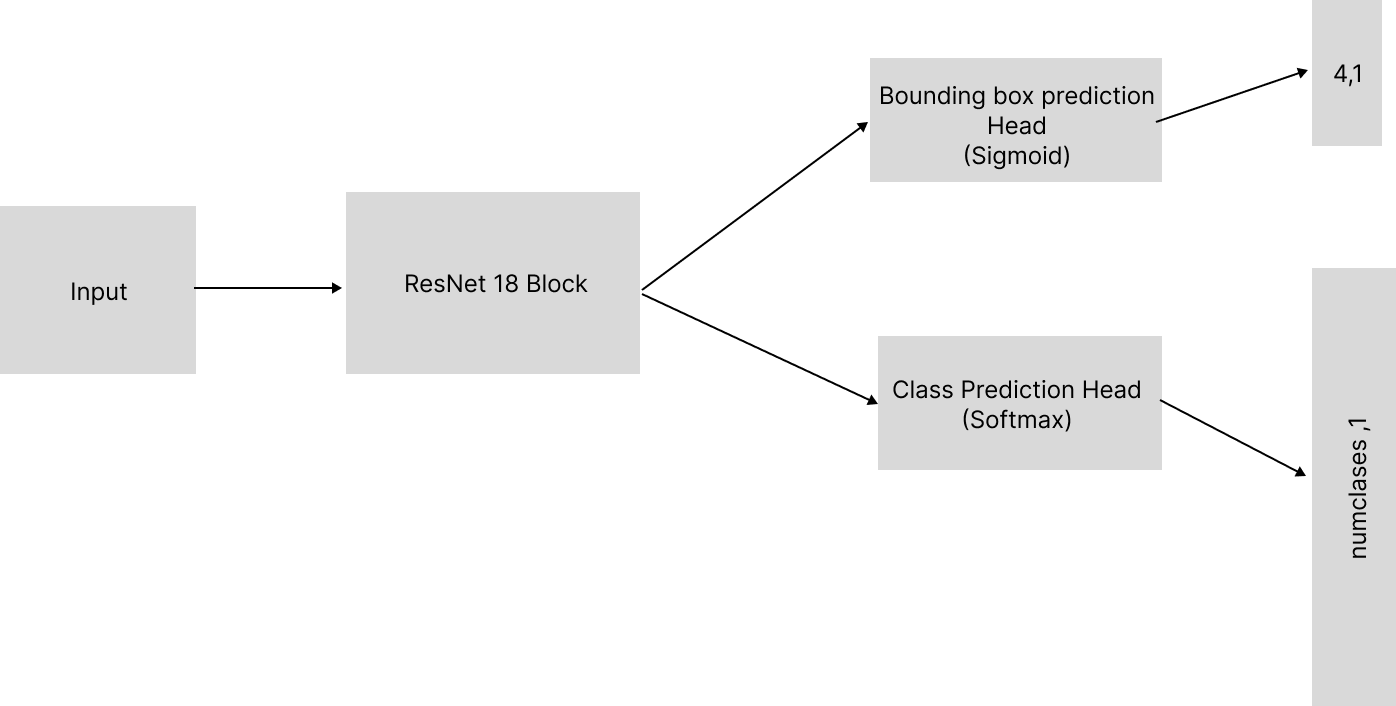

In [ ]:
class ResKANet18PV(nn.Module):
  def __init__(self,
               num_classes,
               feature_ext_output_shape,
               num_channels,
               ):
    super(ResKANet18PV, self).__init__()
    self.in_channels = 64

    self.ResKANet18 = ResKANet18(output_channels=feature_ext_output_shape,
                                 channels = num_channels
                                 )

    self.BBoxHead = nn.Sequential(
        nn.Linear(in_features=feature_ext_output_shape, out_features=128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 4),
        nn.Sigmoid(),
    )

    self.softmaxHead = nn.Sequential(
        nn.Linear(in_features=feature_ext_output_shape, out_features=512),
        nn.Dropout(p=0.5),
        nn.Linear(512, 64),
        nn.Dropout(p=0.5),
        nn.Linear(64, 32),
        nn.Linear(32, num_classes), # Assuming 13 classes
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.ResKANet18(x)
    bbox_output = self.BBoxHead(x)
    print(f'bbox output shape : {bbox_output.shape}')
    softmax_output = self.softmaxHead(x)
    print(f'softmax output shape : {softmax_output.shape}')
    return bbox_output, softmax_output

In [ ]:
testModel_1 = ResKANet18PV(feature_ext_output_shape=24,num_classes=13,num_channels=3)

In [ ]:
bs = 3
input_dim_2d = 3 # Should match the input_dim of model_2
height = 224
width = 224

input_tensor_2d = torch.rand((bs, input_dim_2d, height, width))
input_tensor_2d.shape

torch.Size([3, 3, 224, 224])

In [ ]:
summary(
    model=testModel_1,
        input_size=input_tensor_2d.shape
        )

Input shape :torch.Size([3, 64, 112, 112])
shape :torch.Size([3, 64, 56, 56])
Residual block shape: torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
BT 1 : torch.Size([3, 64, 56, 56])
BT 2 : torch.Size([3, 64, 56, 56])
BT 3 : torch.Size([3, 64, 56, 56])
BT 4 : torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
Botteneck output shape :torch.Size([3, 64, 56, 56])
Residual block shape: torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
BT 1 : torch.Size([3, 64, 56, 56])
BT 2 : torch.Size([3, 64, 56, 56])
BT 3 : torch.Size([3, 64, 56, 56])
BT 4 : torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
Botteneck output shape :torch.Size([3, 64, 56, 56])
shape :torch.Size([3, 64, 56, 56])
Residual block shape: torch.Size([3, 64, 56, 56]) and type: <class 'torch.Tensor'>
BT 1 : torch.Size([3, 128, 56, 56])
BT 2 : torch.Size([3, 128, 28, 28])
BT 3 : torch.Size([3, 128, 28, 28])
BT 4 : torch.Size([3, 128, 28, 28]) and type: <class 'torch.Tensor'>
Botteneck o

Layer (type:depth-idx)                                  Output Shape              Param #
ResKANet18PV                                            [3, 4]                    --
├─ResKANet: 1-1                                         [3, 24]                   --
│    └─KANConv2DLayer: 2-1                              [3, 64, 112, 112]         --
│    │    └─GELU: 3-1                                   [3, 3, 224, 224]          --
│    │    └─ModuleList: 3-2                             --                        9,408
│    │    └─ModuleList: 3-3                             --                        75,264
│    │    └─ModuleList: 3-4                             --                        --
│    │    └─ModuleList: 3-5                             --                        1
│    └─BatchNorm2d: 2-2                                 [3, 64, 112, 112]         128
│    └─ReLU: 2-3                                        [3, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                                